In [1]:
!nvidia-smi

Tue Aug  6 09:32:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [4]:
!pip install -q supervision roboflow jupyter_bbox_widget dataclasses-json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00


## Install Segment Anything Model (SAM) and other dependencies

In [5]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


### Download SAM weights

In [6]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download YOLO pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [8]:
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 2.8G
-rw-r--r-- 1 root root 2.4G Apr  4  2023 sam_vit_h_4b8939.pth
-rw-r--r-- 1 root root  80M May 26 15:53 yolov10b.pt
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root  64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root  11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root  32M May 26 15:54 yolov10s.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


## Download dataset from Roboflow Universe

In [9]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="***********")
project = rf.workspace("golfball-kuu54").project("golf_ball-ooeqc")
version = project.version(2)
dataset = version.download("yolov8")



/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to golf_ball-2 in yolov8:: 100%|██████████| 53228/53228 [00:09<00:00, 5553.50it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [10]:
!ls

golf_ball-2


In [11]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Custom Training

In [12]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

In [13]:
from IPython.display import Image

Train image

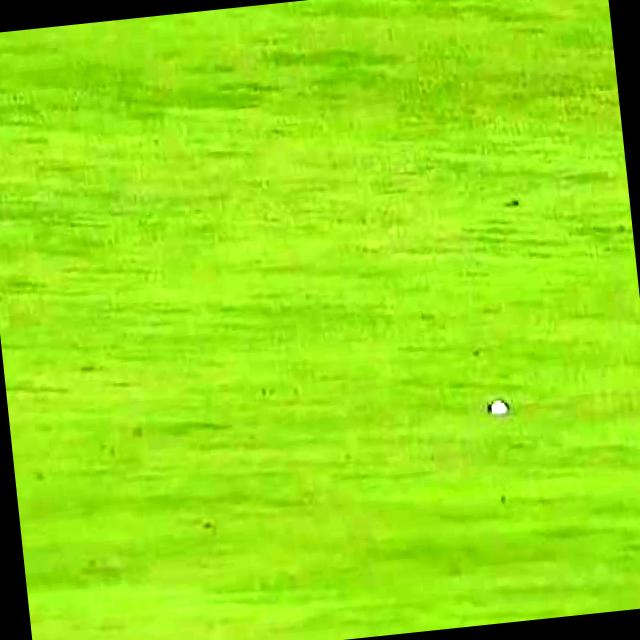

In [14]:
Image(filename=f'{HOME}/datasets/golf_ball-2/train/images/00001_00002_jpg.rf.1753ee715a836b589a5f488c3093812d.jpg', width=600)

Validation image

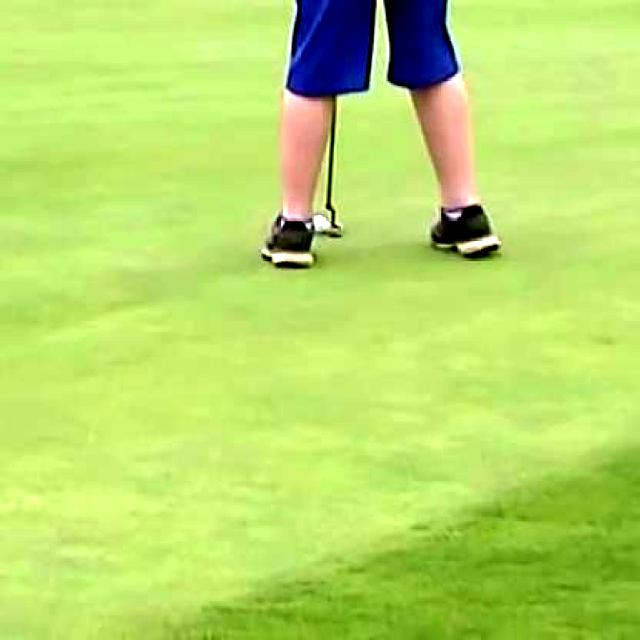

In [15]:
Image(filename=f'{HOME}/datasets/golf_ball-2/valid/images/00055_00006_jpg.rf.d83192d94c2cf421ea304889bd81efa4.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=detect mode=train epochs=5 batch=32 plots=True \
single_cls=True warmup_epochs=1.0 nms=True model={HOME}/weights/best.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.73 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/best.pt, data=/content/datasets/golf_ball-2/data.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1722836422.27db19a23859.6628.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


/content


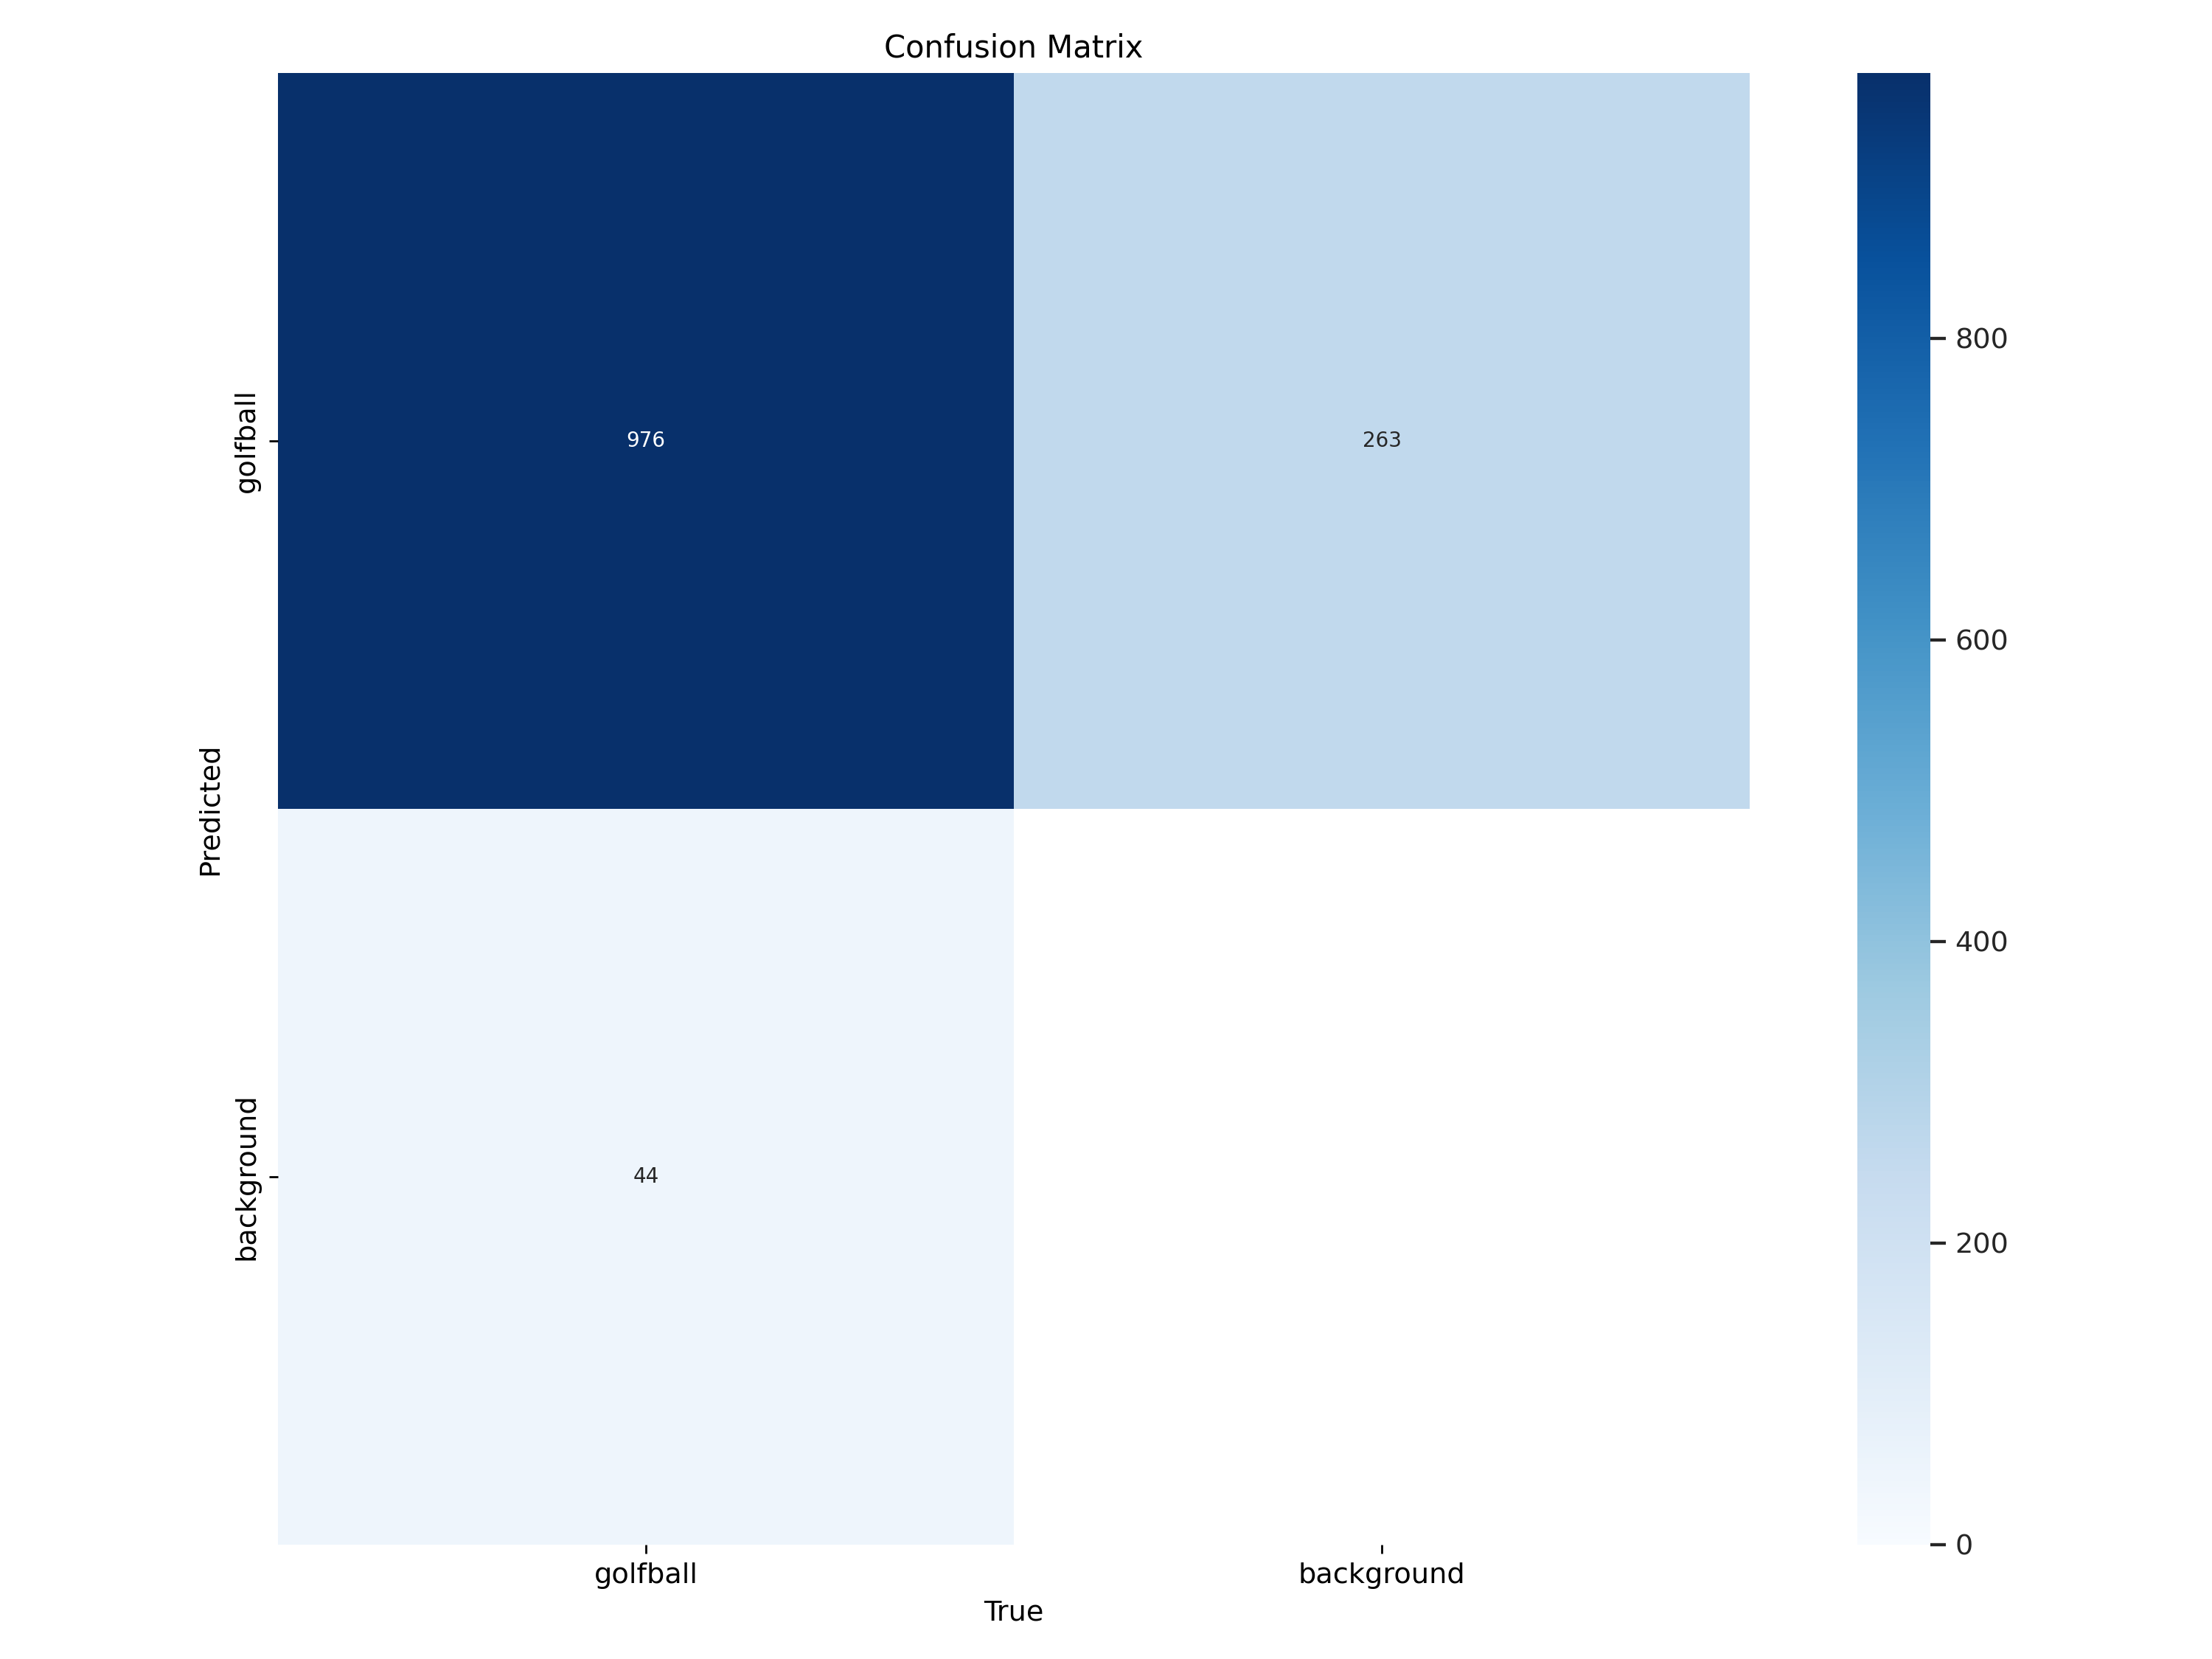

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


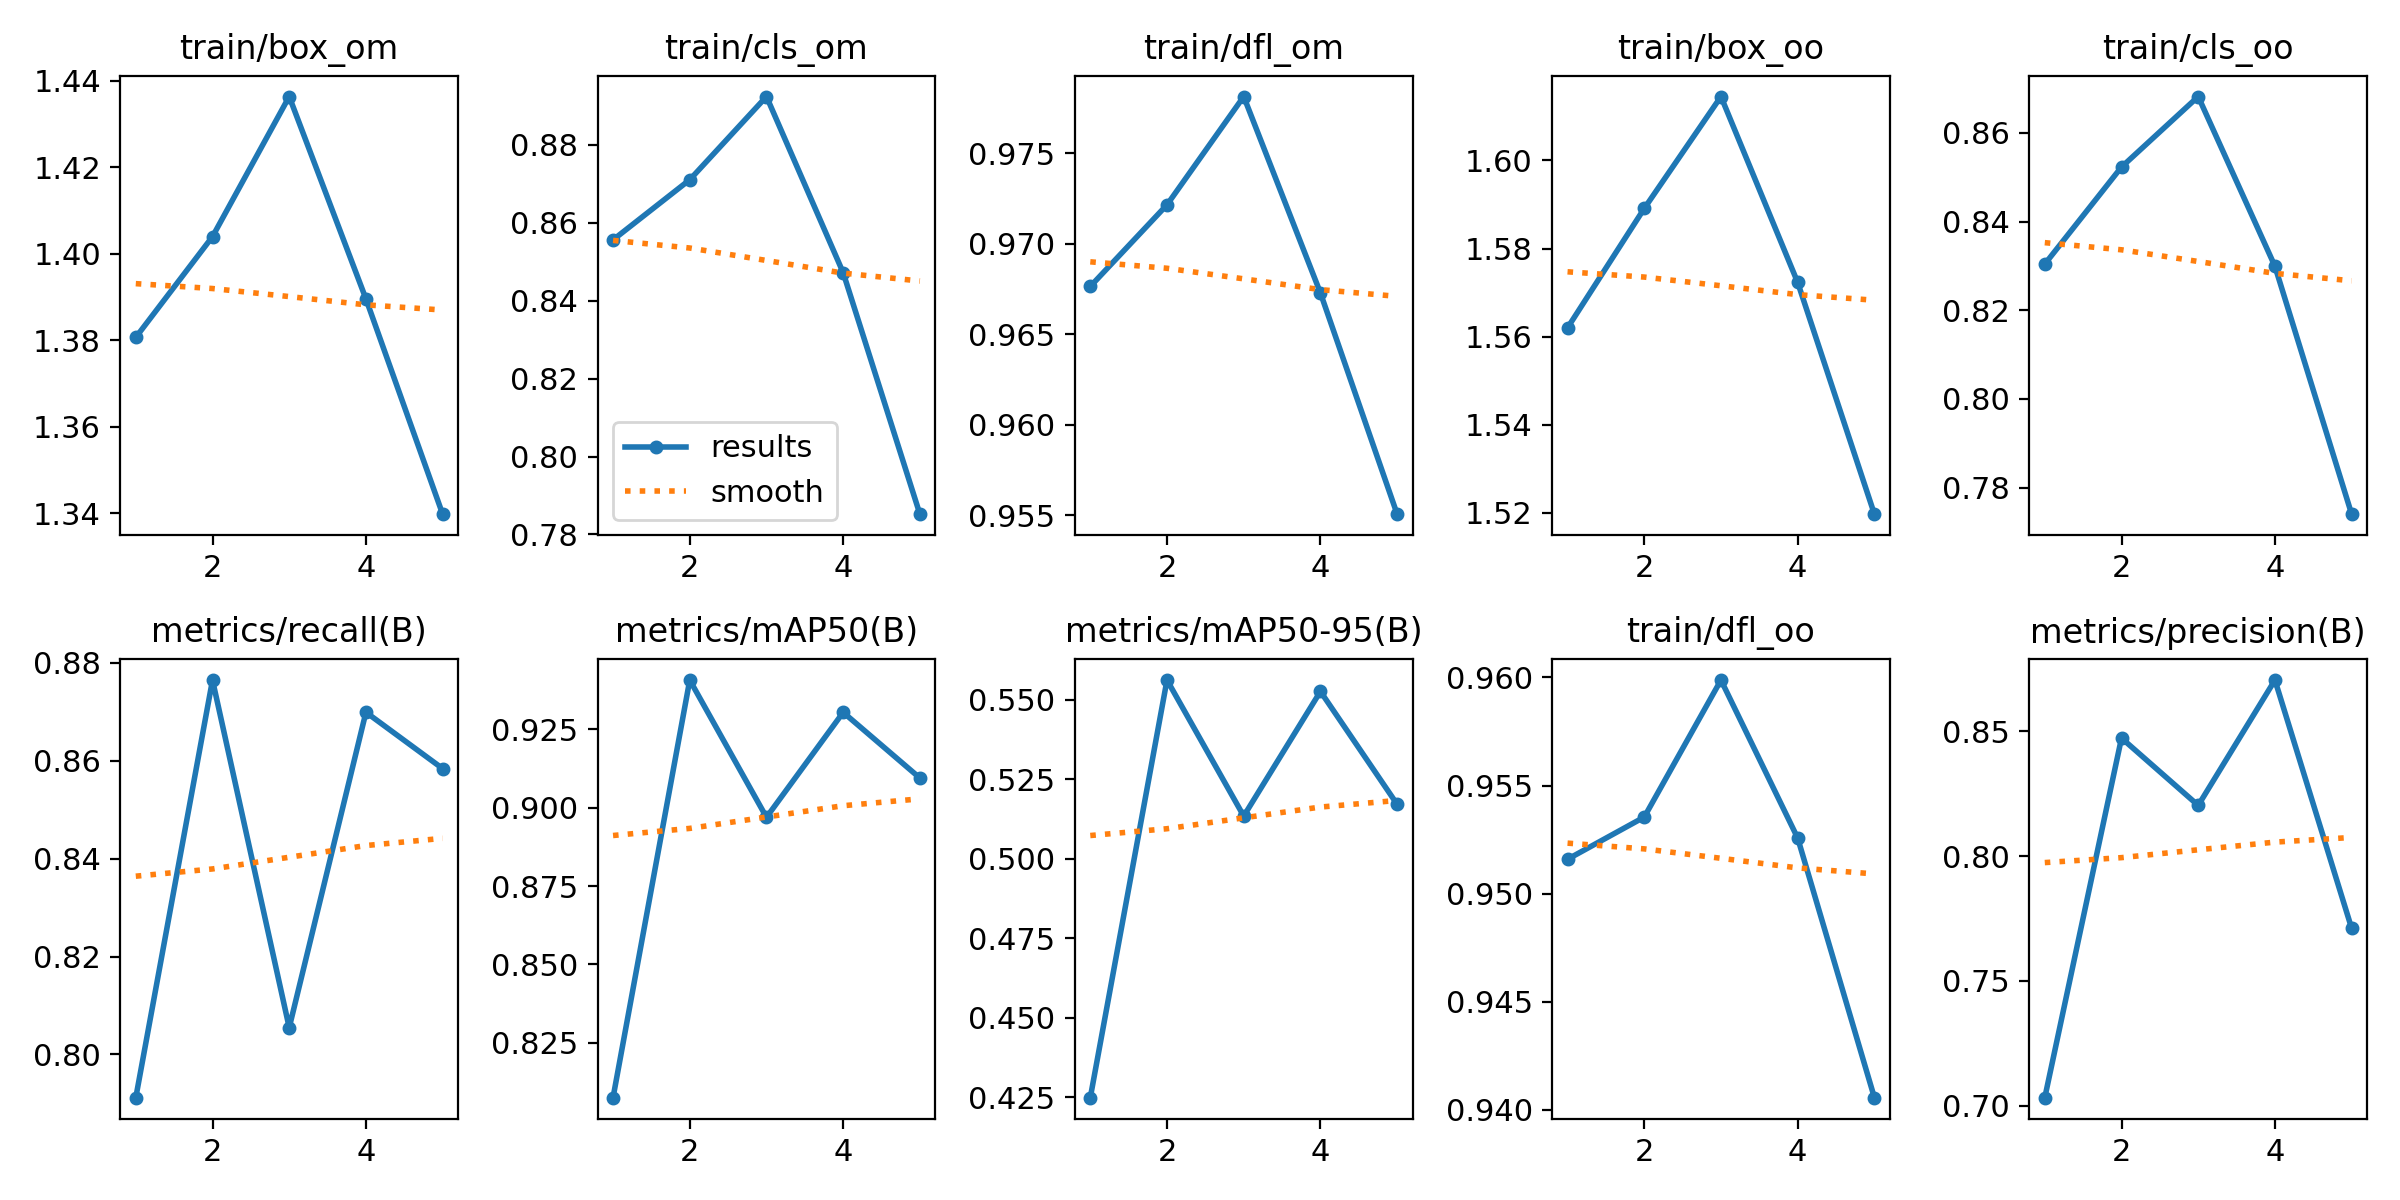

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [16]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


**NOTE:** Let's randomly select an image from our validation set and visualize the results.

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 1 golfball, 16.8ms
Speed: 8.6ms preprocess, 16.8ms inference, 364.7ms postprocess per image at shape (1, 3, 640, 640)


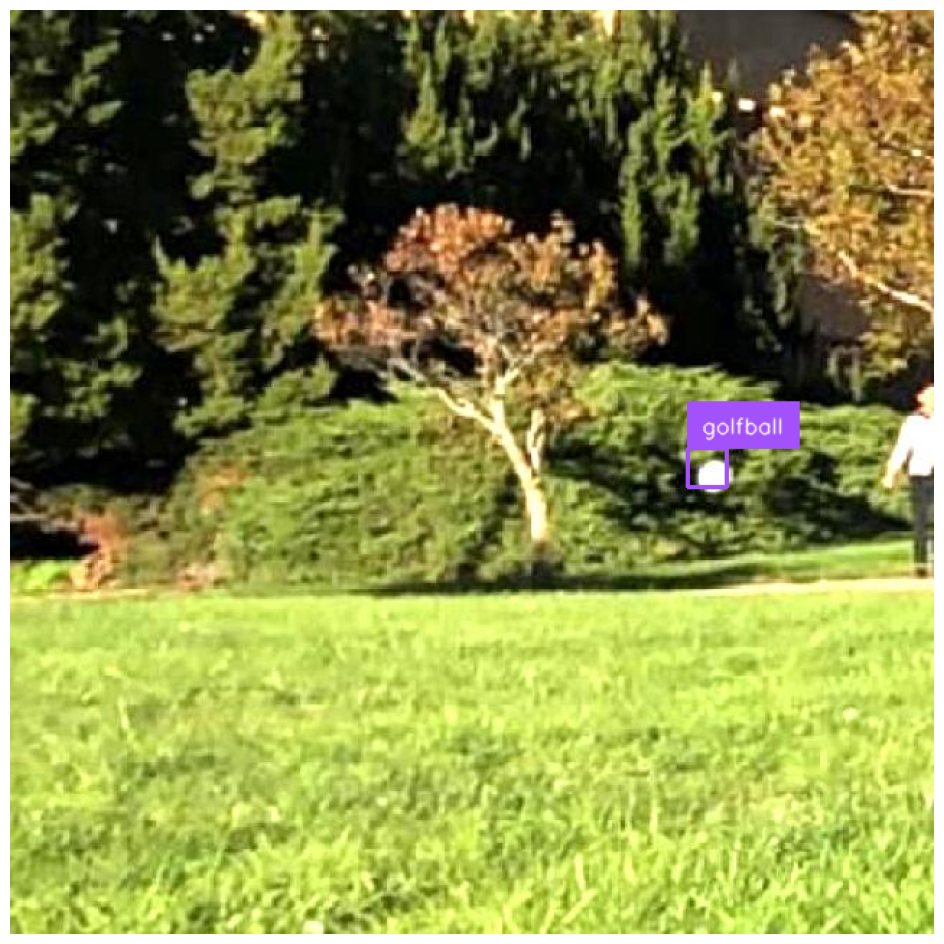

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 1 golfball, 17.7ms
Speed: 2.6ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


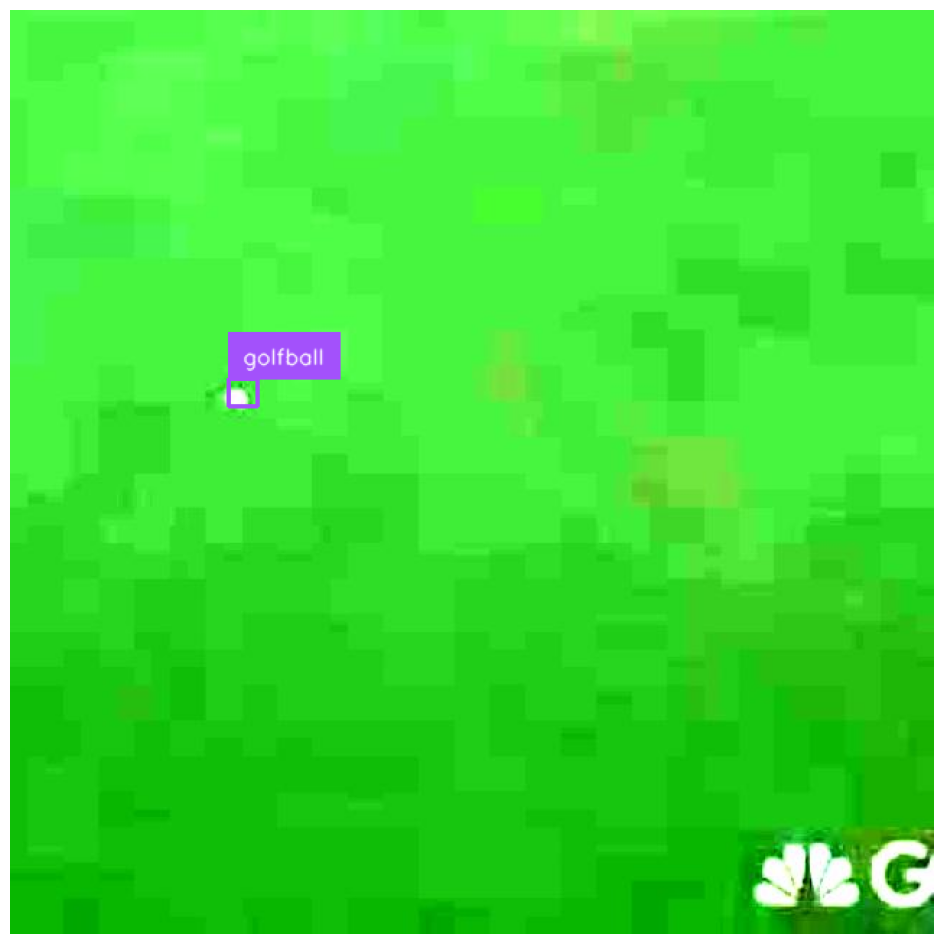

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 2 golfballs, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


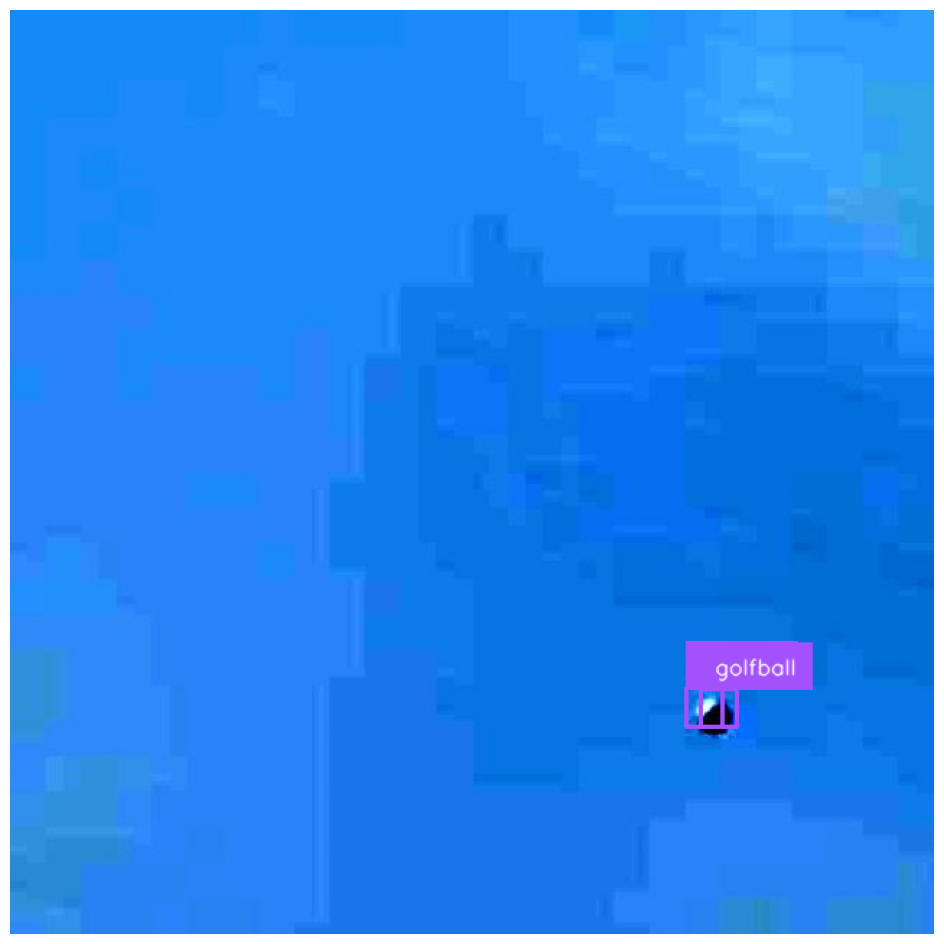

In [17]:
import random
from torchvision.ops import nms

for i in range(3):
  random_image = random.choice(list(dataset.images.keys()))
  random_image = dataset.images[random_image]

  results = model(source=random_image, conf=0.25)[0]
  detections = sv.Detections.from_ultralytics(results)

  annotated_image = bounding_box_annotator.annotate(
      scene=random_image, detections=detections)
  annotated_image = label_annotator.annotate(
      scene=annotated_image, detections=detections)

  sv.plot_image(annotated_image)

In [18]:
import random
random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.45)[0]

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 2 golfballs, 16.9ms
Speed: 3.0ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [19]:
import matplotlib.pyplot as plt
import numpy as np
def show_mask(mask, ax, random_color=False):
  if random_color:
      color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
      color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

In [20]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [21]:
transformed_boxes = mask_predictor.transform.apply_boxes_torch(results[0].boxes.xyxy, random_image.shape[:2])
mask_predictor.set_image(random_image)
masks, _, _ = mask_predictor.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output=False
  )

In [22]:
import numpy as np

# Assuming 'xyxy' is the bounding box array
xyxy = results[0].boxes.xyxy.cpu().numpy()

# Expand the box by a percentage (e.g., 20%)
expansion_factor = 0.5

# Calculate the width and height of the box
width = xyxy[:, 2] - xyxy[:, 0]  # x2 - x1
height = xyxy[:, 3] - xyxy[:, 1]  # y2 - y1

# Calculate the amount to expand on each side
expand_x = width * expansion_factor / 2
expand_y = height * expansion_factor / 2

# Create a new, larger bounding box
new_xyxy = np.zeros_like(xyxy)
new_xyxy[:, 0] = xyxy[:, 0] - expand_x  # x1 - expand_x
new_xyxy[:, 1] = xyxy[:, 1] - expand_y  # y1 - expand_y
new_xyxy[:, 2] = xyxy[:, 2] + expand_x  # x2 + expand_x
new_xyxy[:, 3] = xyxy[:, 3] + expand_y  # y2 + expand_y

# Ensure the coordinates are within image bounds (assuming the image size is known)
image_width, image_height = random_image.shape[1], random_image.shape[0]
new_xyxy[:, 0] = np.clip(new_xyxy[:, 0], 0, image_width - 1)  # x1
new_xyxy[:, 1] = np.clip(new_xyxy[:, 1], 0, image_height - 1)  # y1
new_xyxy[:, 2] = np.clip(new_xyxy[:, 2], 0, image_width - 1)  # x2
new_xyxy[:, 3] = np.clip(new_xyxy[:, 3], 0, image_height - 1)  # y2

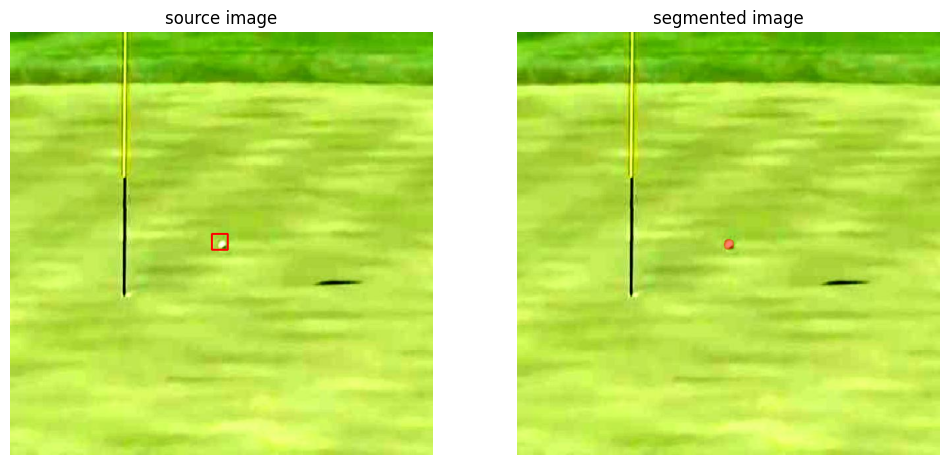

In [ ]:
import supervision as sv
import numpy as np

# Use the sv.Color class for color definition
red_color = sv.Color(255, 0, 0)  # Assuming Color takes RGB values

box_annotator = sv.BoxAnnotator(color=red_color)
mask_annotator = sv.MaskAnnotator(color=red_color, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=new_xyxy,# Use 'new_xyxy' for the SAM model
    mask=masks.cpu().numpy().squeeze(axis=1),
    class_id=np.zeros(len(results[0].boxes.xyxy), dtype=int)
)

detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=random_image.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=random_image.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
